In [7]:
import nltk
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Reshape, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('names')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


True

In [8]:
male_names = nltk.corpus.names.words('male.txt')
female_names = nltk.corpus.names.words('female.txt')

data = [(name, 'male') for name in male_names] + [(name, 'female') for name in female_names]

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

def tokenize_names(data):
    return tokenizer([name for name, _ in data], padding=True, truncation=True, return_tensors="tf")

train_tokens = tokenize_names(train_data)
test_tokens = tokenize_names(test_data)

def get_bert_embeddings(tokens):
    return np.mean(bert_model(tokens)["last_hidden_state"], axis=1)

train_embeddings = get_bert_embeddings(train_tokens)
test_embeddings = get_bert_embeddings(test_tokens)

train_labels = np.array([label == 'female' for _, label in train_data])
test_labels = np.array([label == 'female' for _, label in test_data])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [9]:
inputs = Input(shape=(train_embeddings.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)
model_transformer = Model(inputs=inputs, outputs=outputs)
model_transformer.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_transformer.summary()

history_transformer = model_transformer.fit(train_embeddings, train_labels, epochs=5, batch_size=32)

transformer_loss, transformer_accuracy = model_transformer.evaluate(test_embeddings, test_labels)
print("Transformer-Based Classifier - Test Accuracy:", transformer_accuracy)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_4 (Dense)             (None, 128)               98432     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 98561 (385.00 KB)
Trainable params: 98561 (385.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
199/199 [==============================] - 2s 4ms/step - loss: 0.3964 - accuracy: 0.8245
Epoch 2/5
199/199 [==============================] - 1

In [10]:
inputs = Input(shape=(train_embeddings.shape[1],))
x = Reshape((1, train_embeddings.shape[1]))(inputs)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(64))(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model_lstm = Model(inputs=inputs, outputs=outputs)
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

history_lstm = model_lstm.fit(train_embeddings, train_labels, epochs=5, batch_size=32, validation_split=0.1)

lstm_loss, lstm_accuracy = model_lstm.evaluate(test_embeddings, test_labels)
print("LSTM-Based Classifier - Test Accuracy:", lstm_accuracy)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 768)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 1, 768)            0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 1, 256)            918528    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65  

50/50 [==============================] - 1s 6ms/step


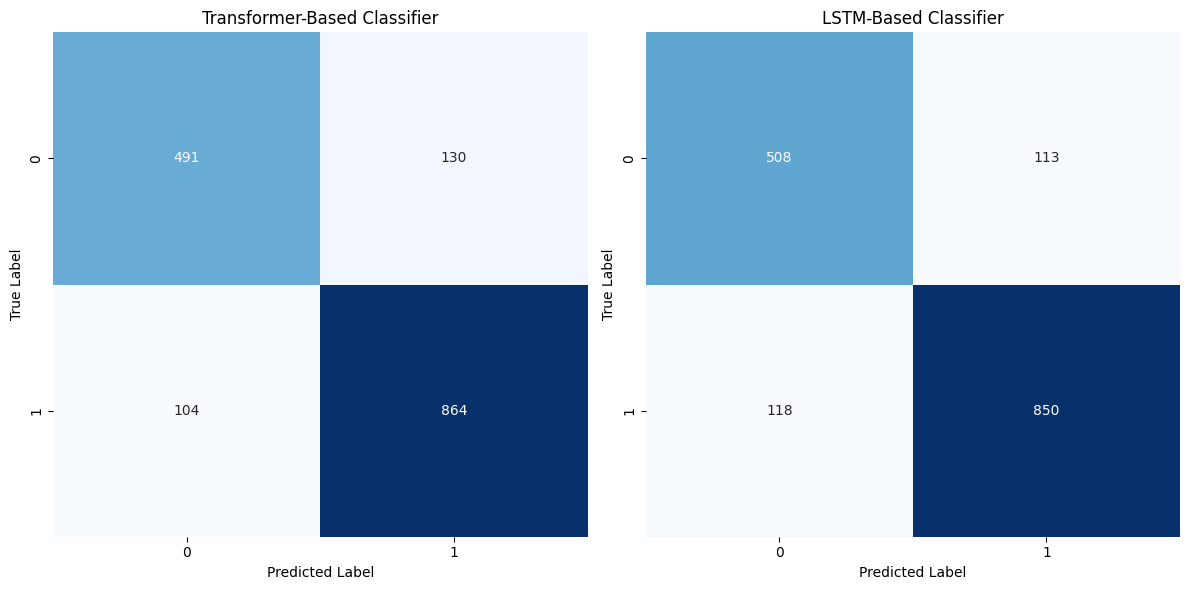

In [11]:
transformer_predictions = (model_transformer.predict(test_embeddings) > 0.5).astype(int)
lstm_predictions = (model_lstm.predict(test_embeddings) > 0.5).astype(int)
transformer_cm = confusion_matrix(test_labels, transformer_predictions)
lstm_cm = confusion_matrix(test_labels, lstm_predictions)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(transformer_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Transformer-Based Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('LSTM-Based Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()


From the confusion matrix we can see the top-left cell of the transformer-based classifier confusion matrix, the model predicted 511 times in transformer while for LSTM it is 489, and these predictions were all correct (true positives). For th

LSTMs may not capture the same level of semantic information as transformer-based models, potentially leading to suboptimal performance on tasks requiring a deep understanding of language semantics.

In summary, while both approaches have their advantages and disadvantages, the choice between encoder-decoder and LSTM approaches depends on factors such as the availability of computational resources, the size of the labeled dataset, and the desired level of performance and generalization.

Overall, by comparing the number of correct predictions 511 to the number of incorrect predictions 110, and for LSTM it is 489 to the number of incorrect predictions 132, we can determine that Transformer model performed better on the classification task.
